In [73]:
import pandas as pd
import numpy as np
import re

In [74]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
del train_data['id']

train_data['keyword'].fillna('none',inplace=True)
train_data['location'].fillna('none',inplace=True)

test_data=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_data['keyword'].fillna('none',inplace=True)
test_data['location'].fillna('none',inplace=True)

train_data=train_data.sample(frac=1)
train_data.head()

,keyword,location,text,target
4337,hijack,none,Swansea ?plot hijack transfer move for Southam...,0
4265,heat%20wave,"Frisco, TX",@wfaaweather Pete when will the heat wave pass...,1
4662,inundated,the Dirty D,@MI_Country_Hick pfft! I wish I had a bot like...,0
149,airplane%20accident,y(our) boyfriends legs,I almost sent my coworker nudes on accident th...,0
3806,fire%20truck,none,Former Township fire truck being used in Phili...,0


In [75]:
def refine_text(text):
    text=re.sub(r'[^a-z\s]',r'',re.sub(r'http\S+',r'',re.sub(r'#','',text).lower()))
    return text

for col in ['keyword','location','text']:
    train_data[col]=train_data[col].apply(lambda x:refine_text(x))
    test_data[col]=test_data[col].apply(lambda x:refine_text(x))

train_data.head()

,keyword,location,text,target
4337,hijack,none,swansea plot hijack transfer move for southamp...,0
4265,heatwave,frisco tx,wfaaweather pete when will the heat wave pass ...,1
4662,inundated,the dirty d,micountryhick pfft i wish i had a bot like tha...,0
149,airplaneaccident,your boyfriends legs,i almost sent my coworker nudes on accident th...,0
3806,firetruck,none,former township fire truck being used in phili...,0


In [76]:
from sklearn.model_selection import train_test_split

train_data,val_data=train_test_split(train_data,test_size=0.1,shuffle=True,random_state=71)
len(train_data),len(val_data)

(6851, 762)

In [18]:
import spacy
spacy_nlp=spacy.load('en')

from nltk.corpus import stopwords
stopword_list=stopwords.words('english')

def tokenizer(text, MAX_LEN=20000):
    text=re.sub(' +',' ',re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]"," ",text))
    text=text if len(text)<=MAX_LEN else text[:MAX_LEN]
    return [x.text for x in spacy_nlp.tokenizer(text) if (x.text!=' ') and (x.text not in stopword_list)]

In [19]:
# https://nlp.stanford.edu/projects/glove/

from torchtext.vocab import Vectors,Vocab
from collections import Counter

gloveVectors=Vectors(name='/kaggle/input/glove6b/glove.6B.100d.txt')

for i in train_data.index:
    counter.update(tokenizer(train_data['text'][i]+' '+train_data['keyword'][i]+' '+train_data['location'][i]))
    
vocabulary=Vocab(counter,max_size=20000,min_freq=2,vectors=gloveVectors,specials=['<pad>','<unk>'])

print('Embedding vocab size: ', vocabulary.vectors.size(0))

Embedding vocab size:  6533


In [20]:
import torchtext 

class ClassifyDataset(torchtext.data.Dataset):
    def __init__(self, df, fields, train=True, **kwargs):
        examples=[]
        for i, row in df.iterrows():
            examples.append(torchtext.data.Example.fromlist([row.text, row.target if train else None],fields))
        super().__init__(examples, fields, **kwargs)
        
    @staticmethod
    def sort_key(x):
        return len(x.text)
    
    @classmethod
    def splits(cls, fields, train_df=None, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data=(None, None, None)
        
        if train_df is not None:
            train_data=cls(train_df.copy(), fields, **kwargs)
            
        if val_df is not None:
            val_data=cls(val_df.copy(), fields, **kwargs)
            
        if test_df is not None:
            test_data=cls(test_df.copy(), fields, train=False, **kwargs)
            
        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [21]:
import torch

Text=torchtext.data.Field(tokenizer, include_lengths=True)
Label=torchtext.data.LabelField(dtype=torch.float)

fields= [('text', Text),('label', Label)]

train_ds, val_ds, test_ds= ClassifyDataset.splits(fields, train_df=train_data, val_df=val_data, test_df=test_data)

#sampling random example
print(vars(train_ds[61]), vars(val_ds[61]))

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Ple

{'text': ['photo', 'prettyboyshyflizzy', 'lol', 'she', 'trapped', 'them', 'into', 'that', 'so', 'beautifully'], 'label': 0} {'text': ['it', 'was', 'a', 'whirlwind', 'love', 'affair', 'that', 'began', 'over', 'back', 'fat', 'and', 'grew', 'into', 'much', 'more'], 'label': 0}


In [22]:
Text.build_vocab(train_ds,
                max_size=20000,
                vectors=gloveVectors,
                unk_init=torch.Tensor.zero_)

Label.build_vocab(train_ds)

In [23]:
batch_size=64
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator= torchtext.data.BucketIterator.splits(
                                (train_ds, val_ds),
                                batch_size=batch_size,
                                sort_within_batch=True,
                                device=device)

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Model - Simple LSTM

In [25]:
num_epochs=20
lr=0.001

input_dims=len(Text.vocab)
embedding_dims=100
hidden_dims=256
output_dims=1
n_layers=2
bidirectional=True
drop=0.2

pad_idx=Text.vocab.stoi[Text.pad_token]

In [36]:
def accuracy(preds, y):
    rounded_preds=torch.round(torch.sigmoid(preds))
    correct=(rounded_preds==y).float()
    return correct.sum()/len(correct)

class LSTMnn(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dims, hidden_dims, output_dims, n_layers, bidirectional,pad_idx, dropout):
        super().__init__()
        self.embeddings=torch.nn.Embedding(vocab_size, embedding_dims, padding_idx=pad_idx)
        self.lstm=torch.nn.LSTM(embedding_dims, hidden_dims,
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        self.fc1=torch.nn.Linear(hidden_dims*2, hidden_dims)
        self.fc2=torch.nn.Linear(hidden_dims, output_dims)
        self.dropout=torch.nn.Dropout(dropout)
        
    def forward(self, text, text_lengths, train=True):
        
        #text and text_lengths : [seq_len, batch_size] and [batch_size]
        embedding=self.embeddings(text) #[seq_len, batch_size, emb_size]
        packed_embeddings=torch.nn.utils.rnn.pack_padded_sequence(embedding, text_lengths)
        packed_out,(hidden,cell)=self.lstm(packed_embeddings)
        #hidden:[num_layers*num_dir, batch size, hidden dims]
        hidden=self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        output=self.fc1(hidden)
        output=self.dropout(self.fc2(output))
        
        return output
        
model=LSTMnn(vocab_size=input_dims,embedding_dims=embedding_dims, 
             hidden_dims=hidden_dims,output_dims=output_dims,
             n_layers=n_layers, bidirectional=bidirectional,
             pad_idx=pad_idx, dropout=drop)

model.embeddings.weight.data.copy_(Text.vocab.vectors)

model.to(device)

criterion=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# for i in train_iterator:
#     model(i.text[0], i.text[1], train=True)
#     break
# torch.Size([1, 4]) tensor([4]) torch.Size([1])
# torch.Size([1, 4, 100]) torch.Size([1])

In [51]:
def train(model, iterator):
    
    epoch_loss=0
    epoch_acc=0
    
    model.train()
    
    for batch in iterator:
        text, text_len=batch.text
        
        optimizer.zero_grad()
        pred=model(text, text_len).squeeze(1)
        
        loss=criterion(pred, batch.label)
        acc=accuracy(pred, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    
    return (epoch_loss/len(iterator), epoch_acc/len(iterator))

def evaluate(model, iterator):

    epoch_acc=0
    
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_len=batch.text

            pred=model(text, text_len).squeeze(1)

            acc=accuracy(pred, batch.label)
            
            epoch_acc+=acc.item()
    
    return epoch_acc/len(iterator)

In [52]:
import time
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.540 | Train Acc: 73.78%
	 Val. Acc: 75.26%
	Train Loss: 0.465 | Train Acc: 77.33%
	 Val. Acc: 84.66%
	Train Loss: 0.428 | Train Acc: 79.25%
	 Val. Acc: 82.55%
	Train Loss: 0.362 | Train Acc: 82.93%
	 Val. Acc: 82.65%
	Train Loss: 0.327 | Train Acc: 84.00%
	 Val. Acc: 66.48%
	Train Loss: 0.282 | Train Acc: 86.14%
	 Val. Acc: 80.19%
	Train Loss: 0.231 | Train Acc: 88.06%
	 Val. Acc: 80.28%
	Train Loss: 0.210 | Train Acc: 88.95%
	 Val. Acc: 79.40%
	Train Loss: 0.186 | Train Acc: 89.45%
	 Val. Acc: 75.79%
	Train Loss: 0.191 | Train Acc: 89.53%
	 Val. Acc: 80.05%
	Train Loss: 0.178 | Train Acc: 89.29%
	 Val. Acc: 78.70%
	Train Loss: 0.174 | Train Acc: 90.13%
	 Val. Acc: 78.81%
	Train Loss: 0.172 | Train Acc: 89.93%
	 Val. Acc: 79.21%
	Train Loss: 0.179 | Train Acc: 89.76%
	 Val. Acc: 76.28%
	Train Loss: 0.169 | Train Acc: 89.93%
	 Val. Acc: 79.36%
	Train Loss: 0.168 | Train Acc: 90.62%
	 Val. Acc: 77.60%
	Train Loss: 0.166 | Train Acc: 89.99%
	 Val. Acc: 75.62%
	Train Loss: 0

In [57]:
print(model)

LSTMnn(
  (embeddings): Embedding(15225, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# torch.save(model.state_dict(),'model.pt')

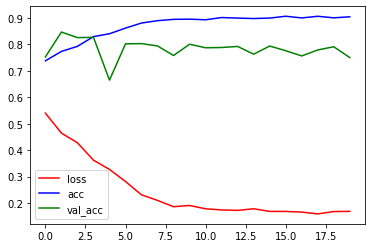

In [53]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss)), loss,color='red',label='loss')
plt.plot(range(len(acc)), acc,color='blue',label='acc')
plt.plot(range(len(val_acc)), val_acc,color='green',label='val_acc')
plt.legend()
plt.show();

In [65]:
def infer(text):
    text_arr=[]
    for i in tokenizer(text):
        text_arr.append(Text.vocab.stoi[i])
        
    if len(text_arr)>0:
        model.eval()
        with torch.no_grad():
#           gpu
#           text=torch.LongTensor([text_arr]).view(-1,1).to(device)
#           text_len=torch.LongTensor([text.shape[1]]).to(device)
            # cpu
            text=torch.LongTensor([text_arr]).view(-1,1)
            text_len=torch.LongTensor([text.shape[1]])
            return int(torch.round(torch.sigmoid(model(text, text_len).squeeze(1))).item())
    else:
        return 0

test_preds=[]
for i in test_data.iterrows():
    test_preds.append(infer(i[1]['text']))

In [ ]:
my_submissions=pd.DataFrame({'id':test_data['id'].values,'target':test_preds})
my_submissions.to_csv('submission.csv', index=False)